In [5]:
from __future__ import division
import sys
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd

In [6]:
from concurrent.futures import ProcessPoolExecutor, wait

In [7]:
from __future__ import division, print_function
import numpy as np
from scipy import optimize as sco
import click

In [8]:
data_t0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuTau_1_1_1.npy',mmap_mode='r')
data_m0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuMu_1_1_1.npy',mmap_mode='r')
data_e0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuE_1_1_1.npy',mmap_mode='r')
data_c0 = np.load('/fastio2/dasha/double_pulse/data_Corsika_11057_11058_10670_trial.npy',mmap_mode='r')

In [9]:
maskl_t = data_t0['logan_veto']['SPE_rlogl']-data_t0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_m = data_m0['logan_veto']['SPE_rlogl']-data_m0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_e = data_e0['logan_veto']['SPE_rlogl']-data_e0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_c = data_c0['logan_veto']['SPE_rlogl']-data_c0['logan_veto']['Cascade_rlogl'] >-0.1
masks_t = (data_t0['preds']['n1'] >= 0.99) & (data_t0['preds']['n4'] >= 0.8)
masks_m = (data_m0['preds']['n1'] >= 0.99) & (data_m0['preds']['n4'] >= 0.8)
masks_e = (data_e0['preds']['n1'] >= 0.99) & (data_e0['preds']['n4'] >= 0.8)
masks_c = (data_c0['preds']['n1'] >= 0.99) & (data_c0['preds']['n4'] >= 0.8)
mask_t = maskl_t & masks_t
mask_m = maskl_m & masks_m
mask_e = maskl_e & masks_e
mask_c = maskl_c & masks_c
data_t = data_t0[mask_t]
data_m = data_m0[mask_m]
data_e = data_e0[mask_e]
data_c = data_c0[mask_c]
print(data_t.shape,data_m.shape,data_e.shape,data_c.shape)

(990,) (51,) (12,) (0,)


990 63


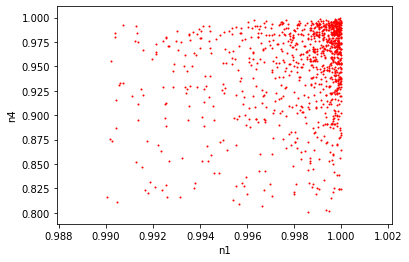

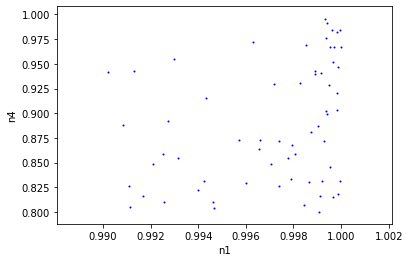

In [10]:
data_t_label = [0]*len(data_t)
array_t = np.array([data_t_label,data_t['preds']['n4'],data_t['preds']['n1'],data_t['weight_val']]).T 
data_m_label = [1]*len(data_m)
array_m = np.array([data_m_label,data_m['preds']['n4'],data_m['preds']['n1'],data_m['weight_val']]).T 
arrs =  array_m
data_e_label = [2]*len(data_e)
array_e = np.array([data_e_label,data_e['preds']['n4'],data_e['preds']['n1'],data_e['weight_val']]).T 
arrs =  np.append(arrs,array_e, axis = 0)
data_c_label = [3]*len(data_c)
array_c = np.array([data_c_label,data_c['preds']['n4'],data_c['preds']['n1'],data_c['weight_val']]).T 
arrs =  np.append(arrs,array_c, axis = 0)
index_values_t = range(len(array_t))
index_values_b = range(len(arrs))
print(len(array_t),len(arrs))
column_values = ['label', 'n4', 'n1','weight'] 
sig_df = pd.DataFrame(data = array_t,  index = index_values_t, columns = column_values) 
bkg_df = pd.DataFrame(data = arrs,  index = index_values_b, columns = column_values)
sig_df.plot(kind='scatter', x='n1', y='n4', s=1, c='r')
bkg_df.plot(kind='scatter', x='n1', y='n4', s=1, c='b')
sig_df.to_csv('/home/dup193/work/double_pulse/max_test/dataframes/sig_out.csv',index=False)
bkg_df.to_csv('/home/dup193/work/double_pulse/max_test/dataframes/bkg_out.csv',index=False)

In [11]:
for i in column_values:
    print(i, np.any([isinstance(val, str) for val in sig_df[i]]))

label False
n4 False
n1 False
weight False


In [12]:
class BinnedPoissonLikelihood():
    '''
    Likelihood: Binned Poisson
    Model: P_B(x) + lmd_S * P_S(x)
    '''
    def __init__(self, sig_hist, bkg_hist, random_state):
        self.sig_hist = sig_hist
        self.bkg_hist = bkg_hist
        self.random_state = check_random_state(random_state)

    def log_likelihood(self, lmd, data_hist):
        expected_hist = (self.bkg_hist + lmd * self.sig_hist)
        result = np.sum(data_hist * np.log(expected_hist) - expected_hist)
        return -result

    def test_statistic(self, lmd, data_hist):
        expected_hist = (self.bkg_hist + lmd * self.sig_hist)
        null_hist = self.bkg_hist
        result = np.sum(data_hist * (np.log(expected_hist) -
                        np.log(null_hist)) - expected_hist + null_hist)
        return -result
    
    def test_statistic_best(self, lmd, true_lmd, data_hist):
        expected_hist = (self.bkg_hist + lmd * self.sig_hist)
        null_hist = (self.bkg_hist + true_lmd * self.sig_hist)
        result = np.sum(data_hist * (np.log(expected_hist) -
                        np.log(null_hist)) - expected_hist + null_hist)
        return -result
    
    def fit_lmd(self, data_hist):
        pars = [0.5]
        par_bounds = [(0, 100)]

        xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
            func=self.test_statistic,
            x0=pars,
            bounds=par_bounds,
            args=(data_hist,),
            approx_grad=True
        )

        # set up mindict to enter while, exit if fit looks nice
        i = 1
        while min_dict["warnflag"] == 2 or b'FACTR' in min_dict["task"]:
            if i > 100:
                print("Did not manage good fit")
                print('results are {}, {}'.format(fmin, xmin))
                return fmin, xmin

            pars[0] = self.random_state.uniform(0., 1.)

            # no stop due to gradient
            xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
                func=self.test_statistic,
                x0=pars,
                bounds=par_bounds,
                args=(data_hist,),
                approx_grad=True
            )
            i += 1

        return fmin, xmin
    
    def fit_lmd_best(self, true_lmd, data_hist):
        pars = [0.5]
        par_bounds = [(0, 100)]

        xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
            func=self.test_statistic_best,
            x0=pars,
            bounds=par_bounds,
            args=(true_lmd, data_hist,),
            approx_grad=True
        )
        #print(xmin,fmin,min_dict)

        #print("min_dict1",min_dict)
        # set up mindict to enter while, exit if fit looks nice
        i = 1
        while min_dict["warnflag"] == 2 or b'FACTR' in min_dict["task"]:
            if i > 100:
                print("Did not manage good fit")
                print('results are {}, {}'.format(fmin, xmin))
                return fmin, xmin

            pars[0] = self.random_state.uniform(0., 1.)

            # no stop due to gradient
            xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
                func=self.test_statistic_best,
                x0=pars,
                bounds=par_bounds,
                args=(true_lmd, data_hist,),
                approx_grad=True
            )
            #print(xmin,fmin,min_dict)
            #print("min_dict",min_dict)
            i += 1

        return fmin, xmin

In [13]:
def get_default_binning():
    bins_x = np.linspace(0.99, 1.0, 5)
    bins_y = np.linspace(0.8, 1.0, 3)
    #bins_y = np.array([0.2, 0.8, 1.])
    return bins_x, bins_y
def build_histograms(sig_df, bkg_df, bins_x, bins_y,
                    # livetime=(3600 * 24 * 365 * 7),
                     density=False,
                     weight_col='weight'):
    #axii are reversed in historgamm2d
    sig, xe, ye = np.histogram2d(
        sig_df['n1'],
        sig_df['n4'],
        bins=[bins_x, bins_y],
        weights=sig_df[weight_col],
        density=density)
   
    bkg, xe, ye = np.histogram2d(
        bkg_df['n1'],
        bkg_df['n4'],
        bins=[bins_x, bins_y],
        weights=bkg_df[weight_col],
        density=density)
    return sig, bkg, xe, ye

def plot_histogram(H,xedges,yedges):
    fig = plt.figure(figsize=(20, 5),facecolor ='w')
    plt.rcParams.update({'font.size': 16})
    plt.ticklabel_format(axis='both', style='sci', scilimits=(-5,5))
    ax = fig.add_subplot()
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, H)
    
def make_hists_and_exps(path, weight_col='weight', livetime=(3600 * 24 * 365 * 7)):
    #sig_df, bkg_df, sig_exp, bkg_exp = load_sample_and_combine_with_add_statistics(
    #        from_cache=True,
    #        cached_path=path,
    #        remove_muongun=False)
    sig_df = pd.read_csv(path+'sig_out.csv')
    #sig_exp = np.sum(sig)
    bkg_df = pd.read_csv(path+'bkg_out.csv')
    
    bins_x, bins_y = get_default_binning()

    sig, bkg, xe, ye = build_histograms(
        sig_df, bkg_df, bins_x, bins_y,
        #livetime=livetime, 
        density=False, weight_col=weight_col)

    sig_exp = np.sum(sig)
    bkg_exp = np.sum(bkg)

    del sig_df
    del bkg_df

    return sig, bkg, sig_exp, bkg_exp


def load_neyman_plane(folder='test_statistics'):
    file_names = glob(os.path.join(folder, '*.npz'))
    mus = np.asarray([float(fn.split('_')[-1].replace('.npz', '')) for fn in file_names])
    sort_idx = np.argsort(mus)
    ts_arrs = np.asarray([np.load(fn)['arr_0'] for fn in file_names])
    sorted_mus = mus[sort_idx]
    sorted_ts_arrs = ts_arrs[sort_idx]
    return sorted_mus, sorted_ts_arrs

In [14]:
#stats.py

def check_random_state(random_state):
    if isinstance(random_state, np.random.RandomState):
        return random_state
    else:
        if not isinstance(random_state, int):
            raise ValueError('random_state has to be either an int or of ' +
                             'type np.random.RandomState!')
        else:
            random_state = np.random.RandomState(random_state)
            return random_state
def sample_from_hist(hist, n_samples, random_state):
    '''Sample `n_samples` from a histogram and return them binned as a
    histogram in the same binning.
    Parameters
    ----------
    hist : ndarray
        Histogram to resample
    n_samples: int
        Number of samples to draw from the histogram
    Returns
    -------
    sampled_hist : ndarray
        Returns a histogram with the same shape of `hist` with `n_samples`
        entries.
    '''
    random_state = check_random_state(random_state)

    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]

    values = random_state.rand(n_samples)
    #print('V',values)
    value_bins = np.searchsorted(cdf, values)

    sampled_hist = np.bincount(value_bins,
                               minlength=np.prod(hist.shape))
    sampled_hist = sampled_hist.reshape(hist.shape)
    #print(sampled_hist)
    return sampled_hist

In [15]:
class SignalInjector(object):
    def __init__(self,
                 sig_dist, bkg_dist,
                 random_state,
                 sig_exp=None, bkg_exp=None):
        if sig_exp is not None:
            self.sig_exp = sig_exp
        else:
            self.sig_exp = np.sum(sig_dist)
        if bkg_exp is not None:
            self.bkg_exp = bkg_exp
        else:
            self.bkg_exp = np.sum(bkg_dist)

        self.sig_dist = sig_dist
        self.bkg_dist = bkg_dist
        self.random_state = check_random_state(random_state)

    def calc_n_events_per_trial(self, n_trials):
        n_sig_per_trial = self.random_state.poisson(lam=self.sig_exp, size=n_trials)
        n_bkg_per_trial = self.random_state.poisson(lam=self.bkg_exp, size=n_trials)
        return n_sig_per_trial, n_bkg_per_trial

    def create_samples(self):
        dists = [self.sig_dist, self.bkg_dist]
        n_samples = [self.n_sig_per_trial,
                     self.n_bkg_per_trial]
        samples_sig, samples_bkg = [], []
        for i, dist in enumerate(dists):
            for j in range(len(n_samples[i])):
                sample = sample_from_hist(dist, n_samples[i][j], self.random_state)
                if i == 0:
                    samples_sig.append(sample)
                elif i == 1:
                    samples_bkg.append(sample)
        self.sig_samples = samples_sig
        self.bkg_samples = samples_bkg
        return samples_sig, samples_bkg
    
    def return_samples(self, n_trials):
        self.n_sig_per_trial, self.n_bkg_per_trial = \
            self.calc_n_events_per_trial(n_trials)

        self.create_samples()
        return np.array(self.sig_samples) + np.array(self.bkg_samples)

    def do_trials(self, n_trials, llh):
        self.n_sig_per_trial, self.n_bkg_per_trial = \
            self.calc_n_events_per_trial(n_trials)

        self.create_samples()

        ts_vals = []
        lmds = []
        
        true_lmd = self.sig_exp / float(np.sum(self.sig_dist))
        #print("true lmd", true_lmd,self.sig_exp,float(np.sum(self.sig_dist)))
        for i in range(n_trials):
        #for i in tqdm(range(n_trials)):
            samples = (self.sig_samples[i] + self.bkg_samples[i])

            ts, lmd = llh.fit_lmd_best(true_lmd, samples)
            ts_vals.append(-ts)
            lmds.extend(lmd)
        # print(np.mean(lmds), np.median(lmds))
        return ts_vals, lmds

In [16]:
def scan_neyman_row(sig_inj, n_samples, likelihood, mu):
    sig_ts,_ = sig_inj.do_trials(
        n_samples, likelihood)
    sig_ts = np.array(sig_ts)
    #lmd = np.array(lmd)
    sig_ts[sig_ts < 0] = 0
    #print(sig_ts, mu)
    return sig_ts, mu

def scan_neyman_plane(sig, bkg, bkg_exp,
                      mu_bins, ts_bins, n_samples_per_mu,
                      n_jobs=1, save=False, out_path=None):
    def save_stuff(out_path, hist, mu):
        if out_path is not None:
            out_path1 = os.path.join(
                out_path, 'ts_mu_{}.npz'.format(mu_i))
            np.savez(out_path1, hist)
            #out_path2 = os.path.join(
            #    out_path, 'lmd_mu_{}.npz'.format(mu_i))
            #np.savez(out_path2, lmd)

    if not save:
        hists = np.zeros((len(mu_bins), len(ts_bins) - 1))
        
    random_state = np.random.RandomState(42)
    likelihood = BinnedPoissonLikelihood(sig, bkg, random_state=random_state)

    if n_jobs > 1:
        with ProcessPoolExecutor(max_workers=n_jobs) as executor:
            futures = []
            for i, mu_i in enumerate(mu_bins):
                injector_rs = np.random.RandomState(i)
                sig_inj = SignalInjector(sig, bkg, injector_rs, sig_exp=mu_i, bkg_exp=bkg_exp)
                futures.append(
                    executor.submit(
                        scan_neyman_row,
                        sig_inj=sig_inj,
                        n_samples=n_samples_per_mu,
                        likelihood=likelihood,
                        mu=mu_i))
            results = wait(futures)
            #print(results)
        for i, future_i in enumerate(results.done):
            try:
                sig_ts, mu_i = future_i.result()
            except Exception as exc:
                print('%r generated an exception: %s' % (future_i, exc))
            #idx = np.where(mu_bins == mu_i)[0][0]
            hist, ts_e = np.histogram(sig_ts, bins=ts_bins)
            hist = hist / float(np.sum(hist))
            if not save:
                hists[idx] = hist
            else:
                save_stuff(out_path, sig_ts, mu_i)

    else:
        #raise NotImplementedError('Adapt to new implementation!')
        for i, mu_i in tqdm(enumerate(mu_bins)):
            injector_rs = np.random.RandomState(i)
            sig_inj = SignalInjector(sig, bkg, injector_rs, sig_exp=mu_i, bkg_exp=bkg_exp)
            sig_ts, mu_i = scan_neyman_row(sig_inj=sig_inj,n_samples=n_samples_per_mu, likelihood=likelihood,mu=mu_i)
            sig_ts = np.array(sig_ts)
            sig_ts[sig_ts < 0] = 0
            hist, ts_e = np.histogram(sig_ts, bins=ts_bins)
            hist = hist / float(np.sum(hist))
            if not save:
                hists[i] = hist
            else:
                save_stuff(out_path, sig_ts, mu_i)

    if not save:
        return hists, ts_e
    else:
        return 0, 0

In [ ]:
n_jobs=20
n_samples=1000
mu_bins = np.linspace(0, 50, 801)
ts_bins = np.linspace(0, 20, 201)
def main(n_jobs, n_samples):
    global mu_bins,ts_bins
    sig_exp, bkg_exp = np.sum(sig_df['weight']), np.sum(bkg_df['weight']) 
    bins_x, bins_y = get_default_binning()
   
    sig, bkg, xe, ye = build_histograms(
        sig_df, bkg_df, bins_x, bins_y,
        weight_col='weight') 
    
    plot_histogram(sig.T,xe,ye)
    plot_histogram(bkg.T,xe,ye)

    ts_bins = ts_bins - np.diff(ts_bins)[0] / 2.
    n_samples_per_mu = n_samples
    out_path ="/home/dup193/work/double_pulse/max_test/ts_dist/"
    if not os.path.isdir(out_path):
        os.makedirs(out_path)
    hists, ts_e = scan_neyman_plane(
        sig, bkg, bkg_exp,
        mu_bins, ts_bins, n_samples_per_mu,
        n_jobs=n_jobs, save=True,
        out_path=out_path)


if __name__ == '__main__':
    main(n_jobs,n_samples)

In [ ]:
from glob import glob
import re
name_out = "/home/dup193/work/double_pulse/max_test/ts_dist/"
mat = []
hists = np.zeros((len(mu_bins), len(ts_bins) - 1))
for file_name in glob(name_out+'*'):
    sp = re.split('_|\.|/',file_name)
    mu = float(sp[-3]+"."+sp[-2])
    i = np.where(mu_bins==mu)
    x = np.load(file_name, mmap_mode="r")['arr_0']
    #print(x)
    hist, ts_e = np.histogram(x, bins=ts_bins)
    hist = hist / float(np.sum(hist))
    hists[i] = hist
#print(mat[0].shape)
#for i in mat:
#    print(i.shape)
#mat = np.stack(mat, axis=0)
#mat = mat.reshape(mat.shape[0],mat[0].shape[0])

In [15]:
print(sum(hists))
#print(mat.shape)

[1.95490e+02 1.34164e+02 8.39170e+01 6.12540e+01 4.86730e+01 3.86440e+01
 3.24710e+01 2.68570e+01 2.30170e+01 1.94840e+01 1.65300e+01 1.47670e+01
 1.22950e+01 1.09550e+01 9.80000e+00 8.30000e+00 7.48700e+00 6.22100e+00
 5.76900e+00 5.00700e+00 4.51200e+00 3.94000e+00 3.54700e+00 2.99600e+00
 2.68100e+00 2.40700e+00 2.18700e+00 1.86300e+00 1.63700e+00 1.51400e+00
 1.31500e+00 1.24800e+00 1.14500e+00 9.34000e-01 8.33000e-01 7.37000e-01
 6.85000e-01 5.94000e-01 5.35000e-01 4.74000e-01 4.18000e-01 4.24000e-01
 3.25000e-01 3.13000e-01 2.99000e-01 2.36000e-01 1.87000e-01 1.92000e-01
 1.75000e-01 1.52000e-01 1.36000e-01 1.27000e-01 1.12000e-01 8.90000e-02
 1.11000e-01 8.00000e-02 6.60000e-02 6.10000e-02 6.20000e-02 5.70000e-02
 4.60000e-02 6.10000e-02 3.80000e-02 4.20000e-02 3.50000e-02 3.10000e-02
 2.40000e-02 2.00000e-02 2.20000e-02 2.10000e-02 1.80000e-02 1.40000e-02
 1.40000e-02 1.20000e-02 6.00000e-03 5.00000e-03 9.00000e-03 7.00000e-03
 7.00000e-03 1.00000e-02 5.00000e-03 6.00000e-03 5.

/home/dup193/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0, 0.5, 'Mean signal expectation $\\mu_t$')

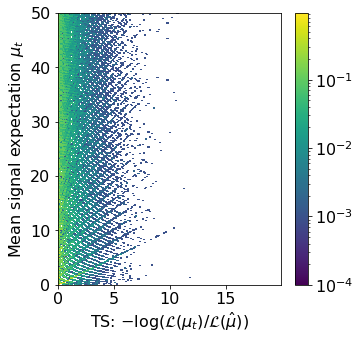

In [16]:
from matplotlib.colors import LogNorm
vmin = np.min([np.min(hist) for hist in hists])
vmax = np.max([np.max(hist) for hist in hists])
fig = plt.figure(figsize=(5, 5),facecolor ='w')
plt.rcParams.update({'font.size': 16})
plt.ticklabel_format(axis='both', style='sci', scilimits=(-5,5))
ax = fig.add_subplot()
for i in range(len(mu_bins) - 1):
    Xe, Ye = np.meshgrid(ts_bins, [mu_bins[i], mu_bins[i+1]])
    im = ax.pcolormesh(Xe, Ye, np.atleast_2d(hists[i]), vmin=vmin+1e-4, vmax=vmax, norm=LogNorm())
plt.colorbar(im)
ax.set_xlabel('TS: $-\log(\mathcal{L}(\mu_t) / \mathcal{L}(\hat{\mu}))$')
ax.set_ylabel(r'Mean signal expectation $\mu_t$')
# plt.savefig('plots/neyman_plane_hans.pdf', bbox_inches='tight')
#ax.imshow(hists,origin='lower',interpolation='none', extent=[0,20,0,20])

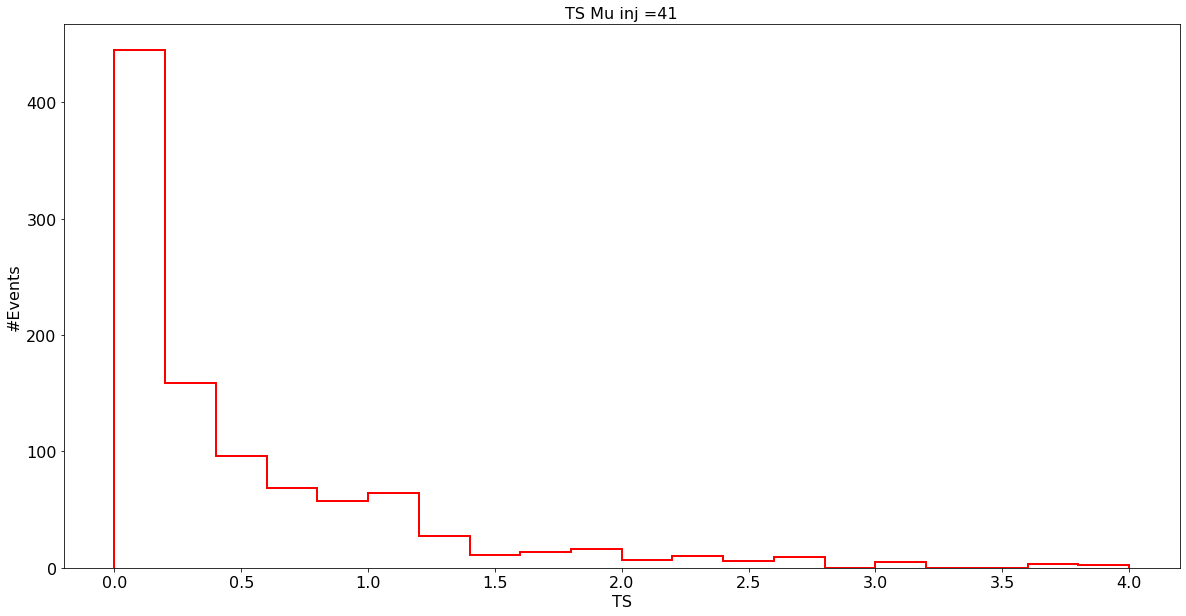

In [17]:
from glob import glob
import re 
file_name = "/home/dup193/work/double_pulse/max_test/ts_dist/ts_mu_41.0.npz"
x = np.load(file_name, mmap_mode="r")['arr_0']
fig = plt.figure(figsize=(20, 10),facecolor ='w')
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 16})
plt.ticklabel_format(axis='both', style='sci', scilimits=(-5,5))
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_title("TS Mu inj =41", fontsize = 16)
ax.set_xlabel("TS", fontsize = 16)                                                              
ax.set_ylabel("#Events", fontsize = 16)                                                   
ax.hist(x, bins = 20, histtype = 'step',edgecolor ='r', lw =2, range =[0,4], label = "NuTauCC")  
#plt.legend(loc=loc)
plt.show()


In [18]:
def get_acc_vals_from_ts_vals(tss, alpha=0.9):
    acc_vals = np.zeros(tss.shape[0])
    n_samples = tss.shape[1]
    for i, row in enumerate(tss):
        critical_val = np.quantile(row, alpha)
        acc_vals[i] = critical_val

    return acc_vals


def calc_limits_from_trials(likelihood, bkg_samples, mus, acceptance_values, signal_expectation):
    lower_limits = []
    upper_limits = []

    for i in tqdm(range(len(bkg_samples))):
        accepted_mus = np.zeros_like(mus, dtype=int)
        ts, lmd_bf = likelihood.fit_lmd(bkg_samples[i])
        for j, mu in enumerate(mus):
            lmd = mu / signal_expectation
            bf_ts = likelihood.test_statistic_best(lmd_bf, lmd, bkg_samples[i])

            if acceptance_values[j] >= (-bf_ts):
                accepted_mus[j] = 1

        accepted_mu_mask = np.array(accepted_mus, dtype=bool)
        lower_limit = np.min(mus[accepted_mu_mask])
        upper_limit = np.max(mus[accepted_mu_mask])
        lower_limits.append(lower_limit)
        upper_limits.append(upper_limit)
    return np.array(lower_limits), np.array(upper_limits)


class LimitCalculator(object):
    def __init__(self, name, flux_systematic,
                 scan_path, df_path=None,
                 livetime=(3600 * 24 * 365 * 7),
                 random_state=1234,
                 alpha=0.9):
        self.name = name
        self.scan_path = scan_path
        self.flux_systematic = flux_systematic
        self.random_state = np.random.RandomState(random_state)
        self.livetime = livetime
        self.alpha = alpha

        if flux_systematic is True:
            #self.df_path = os.path.join(
            #    '/net/nfshome/home/mmeier/level5/loading/',
            #    'cached_dfs_aachen8yr_muongun_add_numu.hd5')
            if df_path is None:
                self.df_path = os.path.join(
                    '/net/nfshome/home/mmeier/level5/loading/',
                    'cached_dfs_aachen8yr_livetime.hd5')
            else:
                self.df_path = df_path
        else:
            self.df_path = os.path.join(
                '/home/dup193/work/double_pulse/max_test/dataframes/')
                #'cached_{}.hd5'.format(self.name))

        self.__load_acceptance_values__()
        self.__load_hists_and_exps__()

    def __load_acceptance_values__(self, return_ts=False):
        mus, tss = load_neyman_plane(self.scan_path)
        self.mus = mus
        self.acc_vals = get_acc_vals_from_ts_vals(tss, alpha=self.alpha)
        if return_ts:
            return tss
        else:
            del tss

    def __load_hists_and_exps__(self):
        if self.flux_systematic:
            if self.name.lower() == 'baseline':
                weight_col = 'weight'
            else:
                splitted_sys = np.append(['Weight_'], self.name.split('_'))
                weight_col = ''.join([split_i.capitalize() for split_i in splitted_sys])
        else:
            weight_col = 'weight'

        sig, bkg, sig_exp, bkg_exp = make_hists_and_exps(
            self.df_path, weight_col, self.livetime)
        self.sig, self.bkg = sig, bkg
        self.sig_exp, self.bkg_exp = sig_exp, bkg_exp

    def set_likelihood(self, likelihood):
        self.likelihood = likelihood

    def create_samples(self, n_samples=1000, bkg_only=True, sig_inj=None):
        if bkg_only and sig_inj is not None:
            raise ValueError('Samples can be either background only or ' +
                             'have a fixed amount of signal events injected!')
        if bkg_only:
            sig_inj = SignalInjector(self.sig, self.bkg,
                                     random_state=self.random_state,
                                     sig_exp=0.)
        elif sig_inj is not None:
            sig_inj = SignalInjector(self.sig, self.bkg,
                                     random_state=self.random_state,
                                     sig_exp=sig_inj)
        else:
            raise ValueError('Either use the bkg_only option or supply ' +
                             'an expected amount of signal!')

        self.samples = sig_inj.return_samples(n_samples)
        self.injected_signal = sig_inj.sig_exp
        return self.samples

    def calculate_limits(self, acc_vals, flux_norm, samples=None):
        if samples is None:
            samples = self.samples
        sig_exp = np.sum(self.likelihood.sig_hist)
        self.lower_limits, self.upper_limits = calc_limits_from_trials(
            self.likelihood, samples, self.mus, acc_vals, sig_exp)

        self.lower_limits_flux = self.lower_limits / sig_exp * flux_norm
        self.upper_limits_flux = self.upper_limits / sig_exp * flux_norm

    def check_coverage(self):
        n_samples_covered = np.sum(np.logical_and(
            self.lower_limits <= self.injected_signal,
            self.upper_limits >= self.injected_signal))
        n_samples_total = len(self.lower_limits)
        return n_samples_covered / n_samples_total

    @property
    def average_upper_limit(self):
        return np.mean(self.upper_limits_flux)

    @property
    def average_lower_limit(self):
        return np.mean(self.lower_limits_flux)

In [19]:
limit_calculator = LimitCalculator(
    'baseline', flux_systematic=False,
     scan_path='/home/dup193/work/double_pulse/max_test/ts_dist/',
     df_path='/home/dup193/work/double_pulse/max_test/dataframes/',
     livetime=1)

In [20]:
likelihood = BinnedPoissonLikelihood(limit_calculator.sig, limit_calculator.bkg, limit_calculator.random_state)
limit_calculator.set_likelihood(likelihood)

In [21]:
tss = limit_calculator.__load_acceptance_values__(return_ts=True)

In [22]:
mus = limit_calculator.mus

In [23]:
ts_bins = np.linspace(0, 20, 501)
ts_bins = ts_bins - np.diff(ts_bins)[0] / 2.
hists = []
for i in range(len(mus)):
    hist_i, edges = np.histogram(tss[i], bins=ts_bins, density=False)
    hist_i = hist_i / float(np.sum(hist_i))
    hists.append(hist_i)

Text(0.5, 0, 'TS')

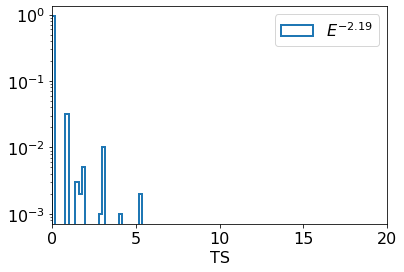

In [24]:
ts_center = (ts_bins[1:] + ts_bins[:-1]) / 2.
plt.hist(ts_center, bins=ts_bins[::5],
         weights=hists[0],
         histtype='step', lw=2,
         label='$E^{-2.19}$')
plt.yscale('log')
plt.xlim(0, 20)
plt.legend()
plt.xlabel('TS')

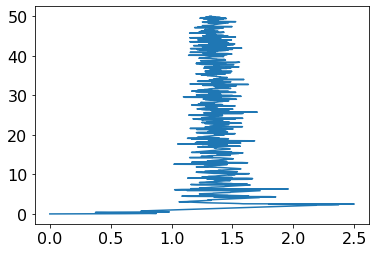

In [25]:
plt.plot(limit_calculator.acc_vals, mus)

Text(0.5, 0, 'TS')

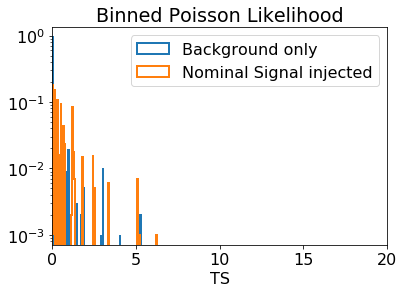

In [26]:
ts_center = (ts_bins[1:] + ts_bins[:-1]) / 2.
plt.title('Binned Poisson Likelihood')
plt.hist(ts_center, bins=ts_bins,
         weights=hists[0],
         histtype='step', lw=2,
         label='Background only')
plt.hist(ts_center, bins=ts_bins,
         weights=hists[81],
         histtype='step', lw=2,
         label='Nominal Signal injected')
plt.yscale('log')
plt.xlim(0, 20)
plt.legend()
plt.xlabel('TS')

No handles with labels found to put in legend.


Text(0.5, 0, 'TS')

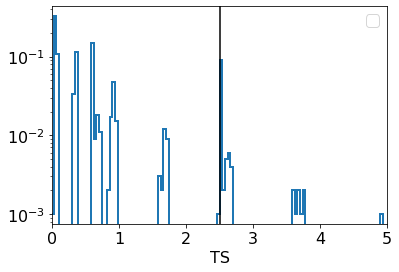

In [27]:
idx = 40
plt.hist(ts_center, bins=ts_bins,
         weights=hists[idx],
         histtype='step', lw=2)
plt.axvline(limit_calculator.acc_vals[idx], color='k')
plt.yscale('log')
plt.xlim(0, 5)
plt.legend()
plt.xlabel('TS')

In [28]:
samples_bkg = limit_calculator.create_samples()

In [29]:
lmds = np.linspace(0, 30, 301)

llh_vals = []
for lmdi in lmds:
    llh_val = likelihood.log_likelihood(lmdi, samples_bkg[7])
    llh_vals.append(llh_val)

ts_vals = []
for lmdi in lmds:
    _, lmd = likelihood.fit_lmd_best(lmdi, samples_bkg[7])
    ts_val = likelihood.test_statistic_best(
        lmd, lmdi, samples_bkg[7])
    ts_vals.append(-ts_val)

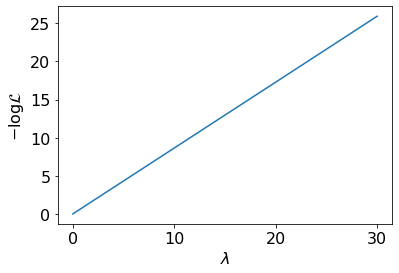

In [30]:
plt.plot(lmds, llh_vals)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$-\log \mathcal{L}$');

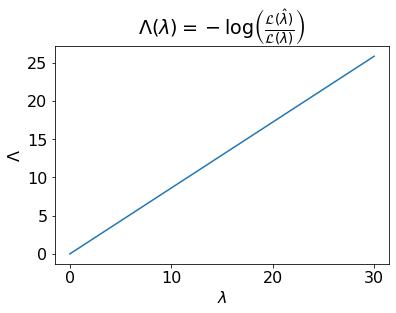

In [31]:
plt.plot(lmds, ts_vals)
plt.title(r'$\Lambda(\lambda) = - \log \left(\frac{\mathcal{L}(\hat{\lambda})}{\mathcal{L}(\lambda)} \right)$')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\Lambda$');

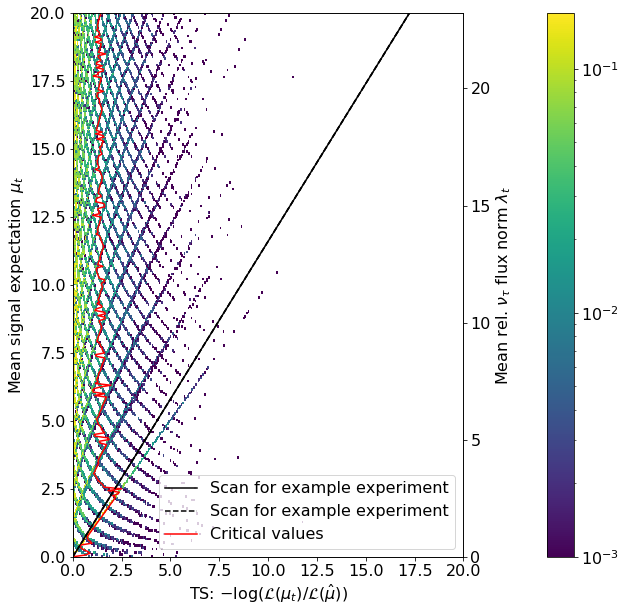

In [32]:
vmin = np.min([np.min(hist) for hist in hists])
vmax = np.max([np.max(hist) for hist in hists])

ts_vals = []
for mu in mus:
    lmd = mu / limit_calculator.sig_exp
    ts_val, lmd = likelihood.fit_lmd_best(mu, samples_bkg[81])
    ts_vals.append(-ts_val)
    
ts_vals2 = []
for mu in mus:
    lmd = mu / limit_calculator.sig_exp
    ts_val, lmd = likelihood.fit_lmd_best(mu, samples_bkg[0])
    ts_vals2.append(-ts_val)

fig, ax = plt.subplots(figsize=(10, 10),facecolor ='w')
for i in range(len(mus) - 1):
    Xe, Ye = np.meshgrid(ts_bins, [mus[i], mus[i+1]])
    im = ax.pcolormesh(Xe, Ye, np.atleast_2d(hists[i]), norm=LogNorm())# , vmin=vmin+1e-4, vmax=vmax
plt.plot(ts_vals, mus, color='k', label='Scan for example experiment')
plt.plot(ts_vals2, mus, color='k', ls='--', label='Scan for example experiment')
plt.plot(limit_calculator.acc_vals, mus, color='r', label='Critical values')
ax.set_xlabel('TS: $-\log(\mathcal{L}(\mu_t) / \mathcal{L}(\hat{\mu}))$')
ax.set_ylabel(r'Mean signal expectation $\mu_t$')
plt.xlim(0, 20)
ylim_lower = 0
ylim_upper = 20
plt.ylim(ylim_lower, ylim_upper)
plt.legend()
ax2 = ax.twinx()
ax2.set_ylabel(r'Mean rel. $\nu_{\tau}$ flux norm $\lambda_t$')
ax2.plot(ts_vals2, mus/limit_calculator.sig_exp, color='k', ls='--', label='Scan for example experiment')
ax2.set_ylim(ylim_lower/limit_calculator.sig_exp, ylim_upper/limit_calculator.sig_exp)
plt.colorbar(im, pad=0.15)

In [33]:
flux_norm = 2.46
limit_calculator.calculate_limits(limit_calculator.acc_vals, flux_norm)

100%|██████████| 1000/1000 [00:14<00:00, 67.81it/s]


In [34]:
limit_calculator.average_upper_limit

7.307340957102156

Text(0.5, 1.0, 'Fitting with $E^{-2.5}$')

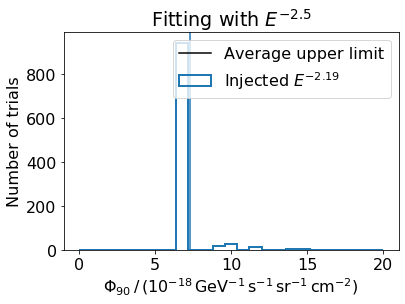

In [36]:
ul_bins = np.linspace(0, 20, 26)
plt.hist(limit_calculator.upper_limits_flux, bins=ul_bins, histtype='step', lw=2, label='Injected $E^{-2.19}$')
plt.axvline(limit_calculator.average_upper_limit)
plt.plot([], [], color='k', ls='-', label='Average upper limit')
plt.legend()
plt.xlabel('$\Phi_{90} \, / \, (10^{-18} \, \mathrm{GeV}^{-1} \, \mathrm{s}^{-1} \, \mathrm{sr}^{-1} \, \mathrm{cm}^{-2})$')
plt.ylabel('Number of trials')
plt.title('Fitting with $E^{-2.5}$')